# Game Prototype of Team Scotland #2
Felix Zaussinger, Martina Buck | 01.12.2020, 15:30

======================================================================================================================

                                            GAME CONFIGURATION

======================================================================================================================

**Magic commands**

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**External imports**

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import configparser
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

**Figure properties**

In [3]:
sns.set_context("poster")
sns.set(rc={'figure.figsize': (8, 5)})
sns.set_style("ticks")

**Directory structure**

In [4]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "plots")
project_dir

'/Users/felix/ETH/code/gecm'

**Append project directory to PYTHONPATH via sys (!)**

Source: https://stackoverflow.com/questions/39299838/how-do-i-import-module-in-jupyter-notebook-directory-into-notebooks-in-lower-dir

In [5]:
if project_dir not in sys.path:
    sys.path.append(project_dir)

#### import our own code from src

In [6]:
from src.gecm.game import MatrixGame
from src.gecm import model, vis, io, game, base, dicts
from src.gecm.dicts import (
        original_lulc_mapping,
        lulc_remapping,
        simplified_lulc_mapping,
        simplified_lulc_mapping_colors
    )

#### Game parameters

In [7]:
# size of playing field in pixels
n_pixels = 80

# complexity of playing field (only granularity = 1 works for now)
granularity = 1

# colormap
simplified_lulc_cm = ListedColormap(
    [simplified_lulc_mapping_colors[x] for x in simplified_lulc_mapping_colors.keys()]
)

# path to raster data file (must be a geotiff)
fpath_map = os.path.join(
    data_processed, "NFI_rasterized_{}_{}.tif".format(n_pixels, n_pixels)
)

#### Configuration file

In [8]:
# init config file parser. methods: config.getboolean, config.getint, ... .
config = configparser.ConfigParser()
fpath_cf = os.path.join(project_dir, 'config.ini')
config.read(fpath_cf)

['/Users/felix/ETH/code/gecm/config.ini']

#### Google Drive Connection

In [9]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = [config.get(section="default", option="scopes")]

# API credentials
credentials_fpath = os.path.join(project_dir, 'google_api_credentials.json')

#### Conceptual model parameters & calculations

In [10]:
%reload_ext autoreload
model_settings_dict = io.parse_sheets(
        spreadsheet_id=config.get(section="gdrive_spreadsheet_ids", option="spreadsheet_id_model"), 
        sheets=io.parse_list(config_string=config.get(section="gdrive_sheet_names", option="sheet_names_model")),
        credentials_fpath=credentials_fpath, 
        scopes=SCOPES,
        to_numeric=True
    )

# extract model_parameters as dictionary
model_parameters_dict = model_settings_dict["model_parameters"].loc[:, ["variable", "value"]].set_index("variable").to_dict()["value"]

# add model_parameters to config file
config['model_parameters'] = model_parameters_dict

#### Playing field

In [11]:
%reload_ext autoreload
matrix_game = MatrixGame(
    fpath=fpath_map,
    original_lulc_mapping=original_lulc_mapping,
    simplified_lulc_mapping=simplified_lulc_mapping,
    lulc_remapping=lulc_remapping,
    model_param_dict=model_parameters_dict,
    config_file=config,
    credentials_fpath=credentials_fpath
)

# initialise playing field (crucial, else nothing works!)
matrix_game.initialise(granularity=1)

# sanity check on current round
assert matrix_game.current_round == 0

# quick-fix based on: https://stackoverflow.com/questions/4357851/creating-or-assigning-variables-from-a-dictionary-in-python
locals().update(matrix_game.model_param_dict)

======================================================================================================================

                                            START OF ACTUAL GAME

======================================================================================================================

### Starting Point ("Year 0")

In [12]:
assert matrix_game.current_round == 0

####  Dashboard

In this year, 1000 tourists visited the biosphere.


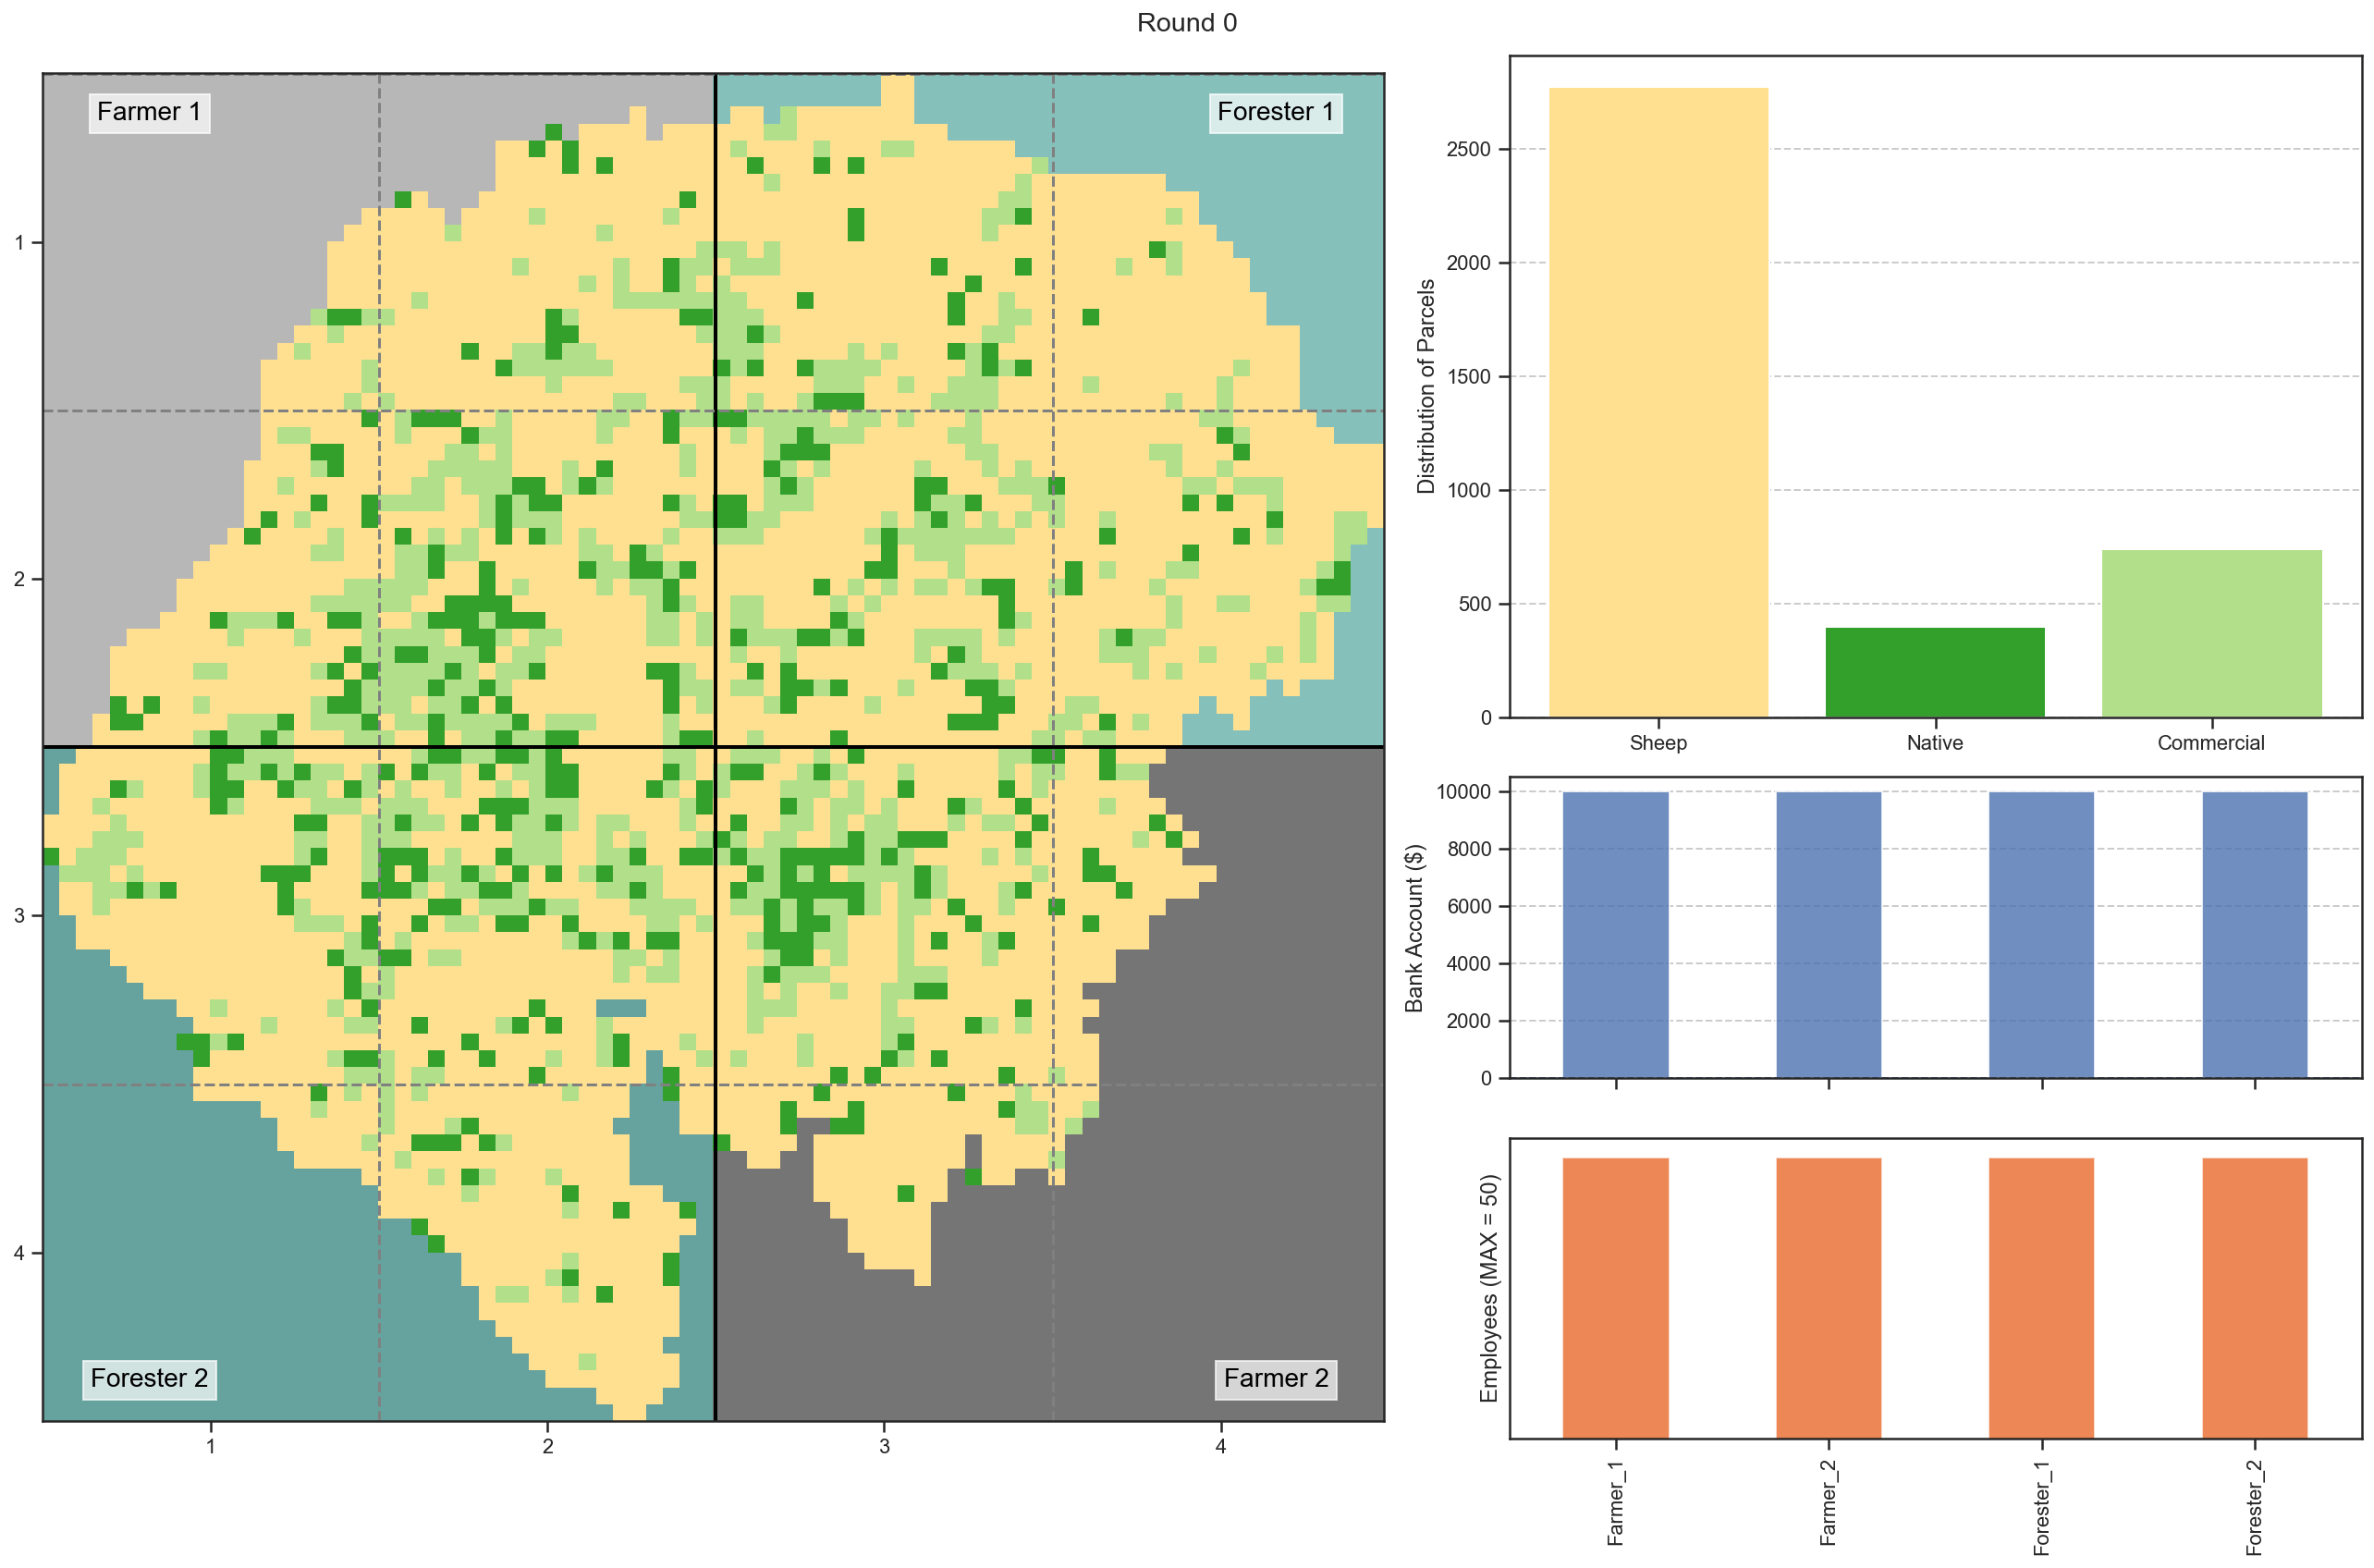

In [13]:
%reload_ext autoreload
matrix_game.show_dashboard(figure_size=(18,12), property_rights=True, cattle=False)

In [14]:
assert 1 == 2

AssertionError: 

### Year 1

4
4
4
In this year, 803 tourists visited the biosphere.


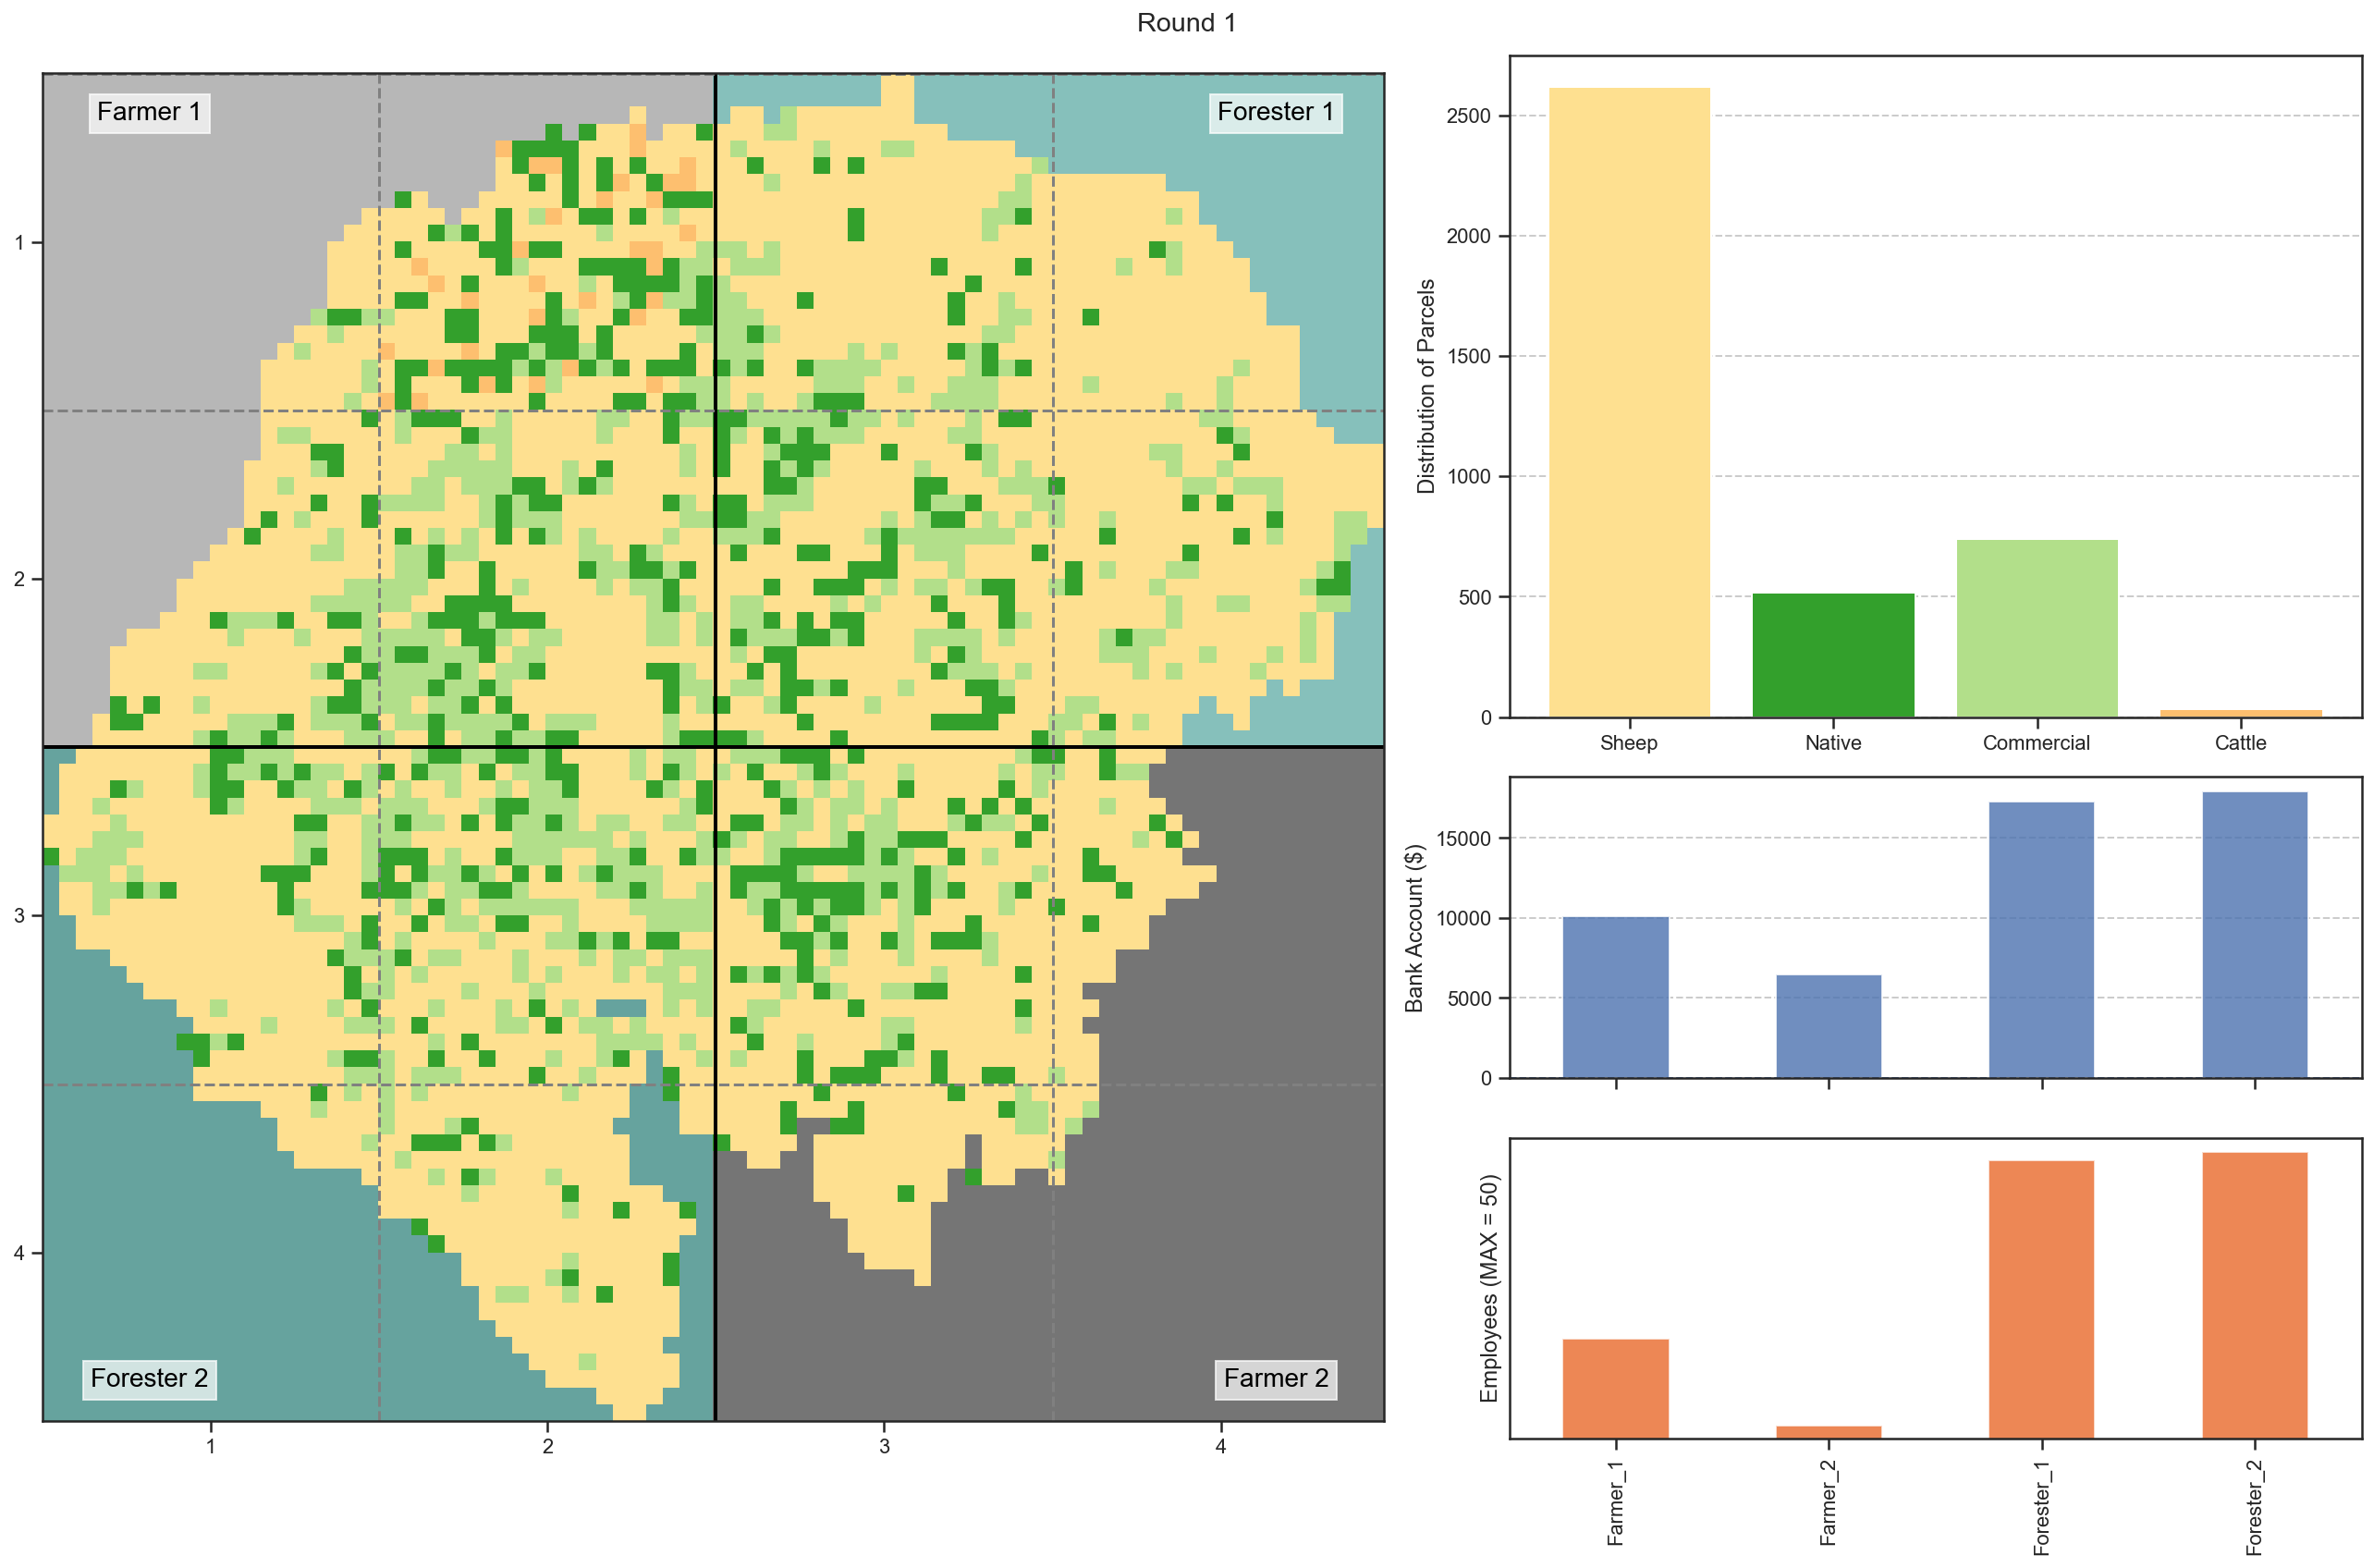

In [15]:
%reload_ext autoreload

# --------------------------------------------------------------------------
# 0. Updating round number
# --------------------------------------------------------------------------
matrix_game.update_round_number()
assert matrix_game.current_round == 1

# --------------------------------------------------------------------------
# 1. Downloading management decisions
# --------------------------------------------------------------------------

# download mgmt decisions
matrix_game.fetch_mgmt_decisions()

# visualize
# matrix_game.show_all_mgmt_decisions()

# --------------------------------------------------------------------------
# 2. Updating landscape
# --------------------------------------------------------------------------
matrix_game.update_lulc_matrix_based_on_mgmt_decisions(current_round=None)

# --------------------------------------------------------------------------
# 3. Updating property, incomes, bank accounts, and unemployment rates
# --------------------------------------------------------------------------
matrix_game.update_data_store(ssda_choice=22)

# --------------------------------------------------------------------------
# 4. Visualizing new dashboard
# --------------------------------------------------------------------------
matrix_game.show_dashboard(figure_size=(18,12), property_rights=True, cattle=True)

## Year 2

4
4
In this year, 713 tourists visited the biosphere.


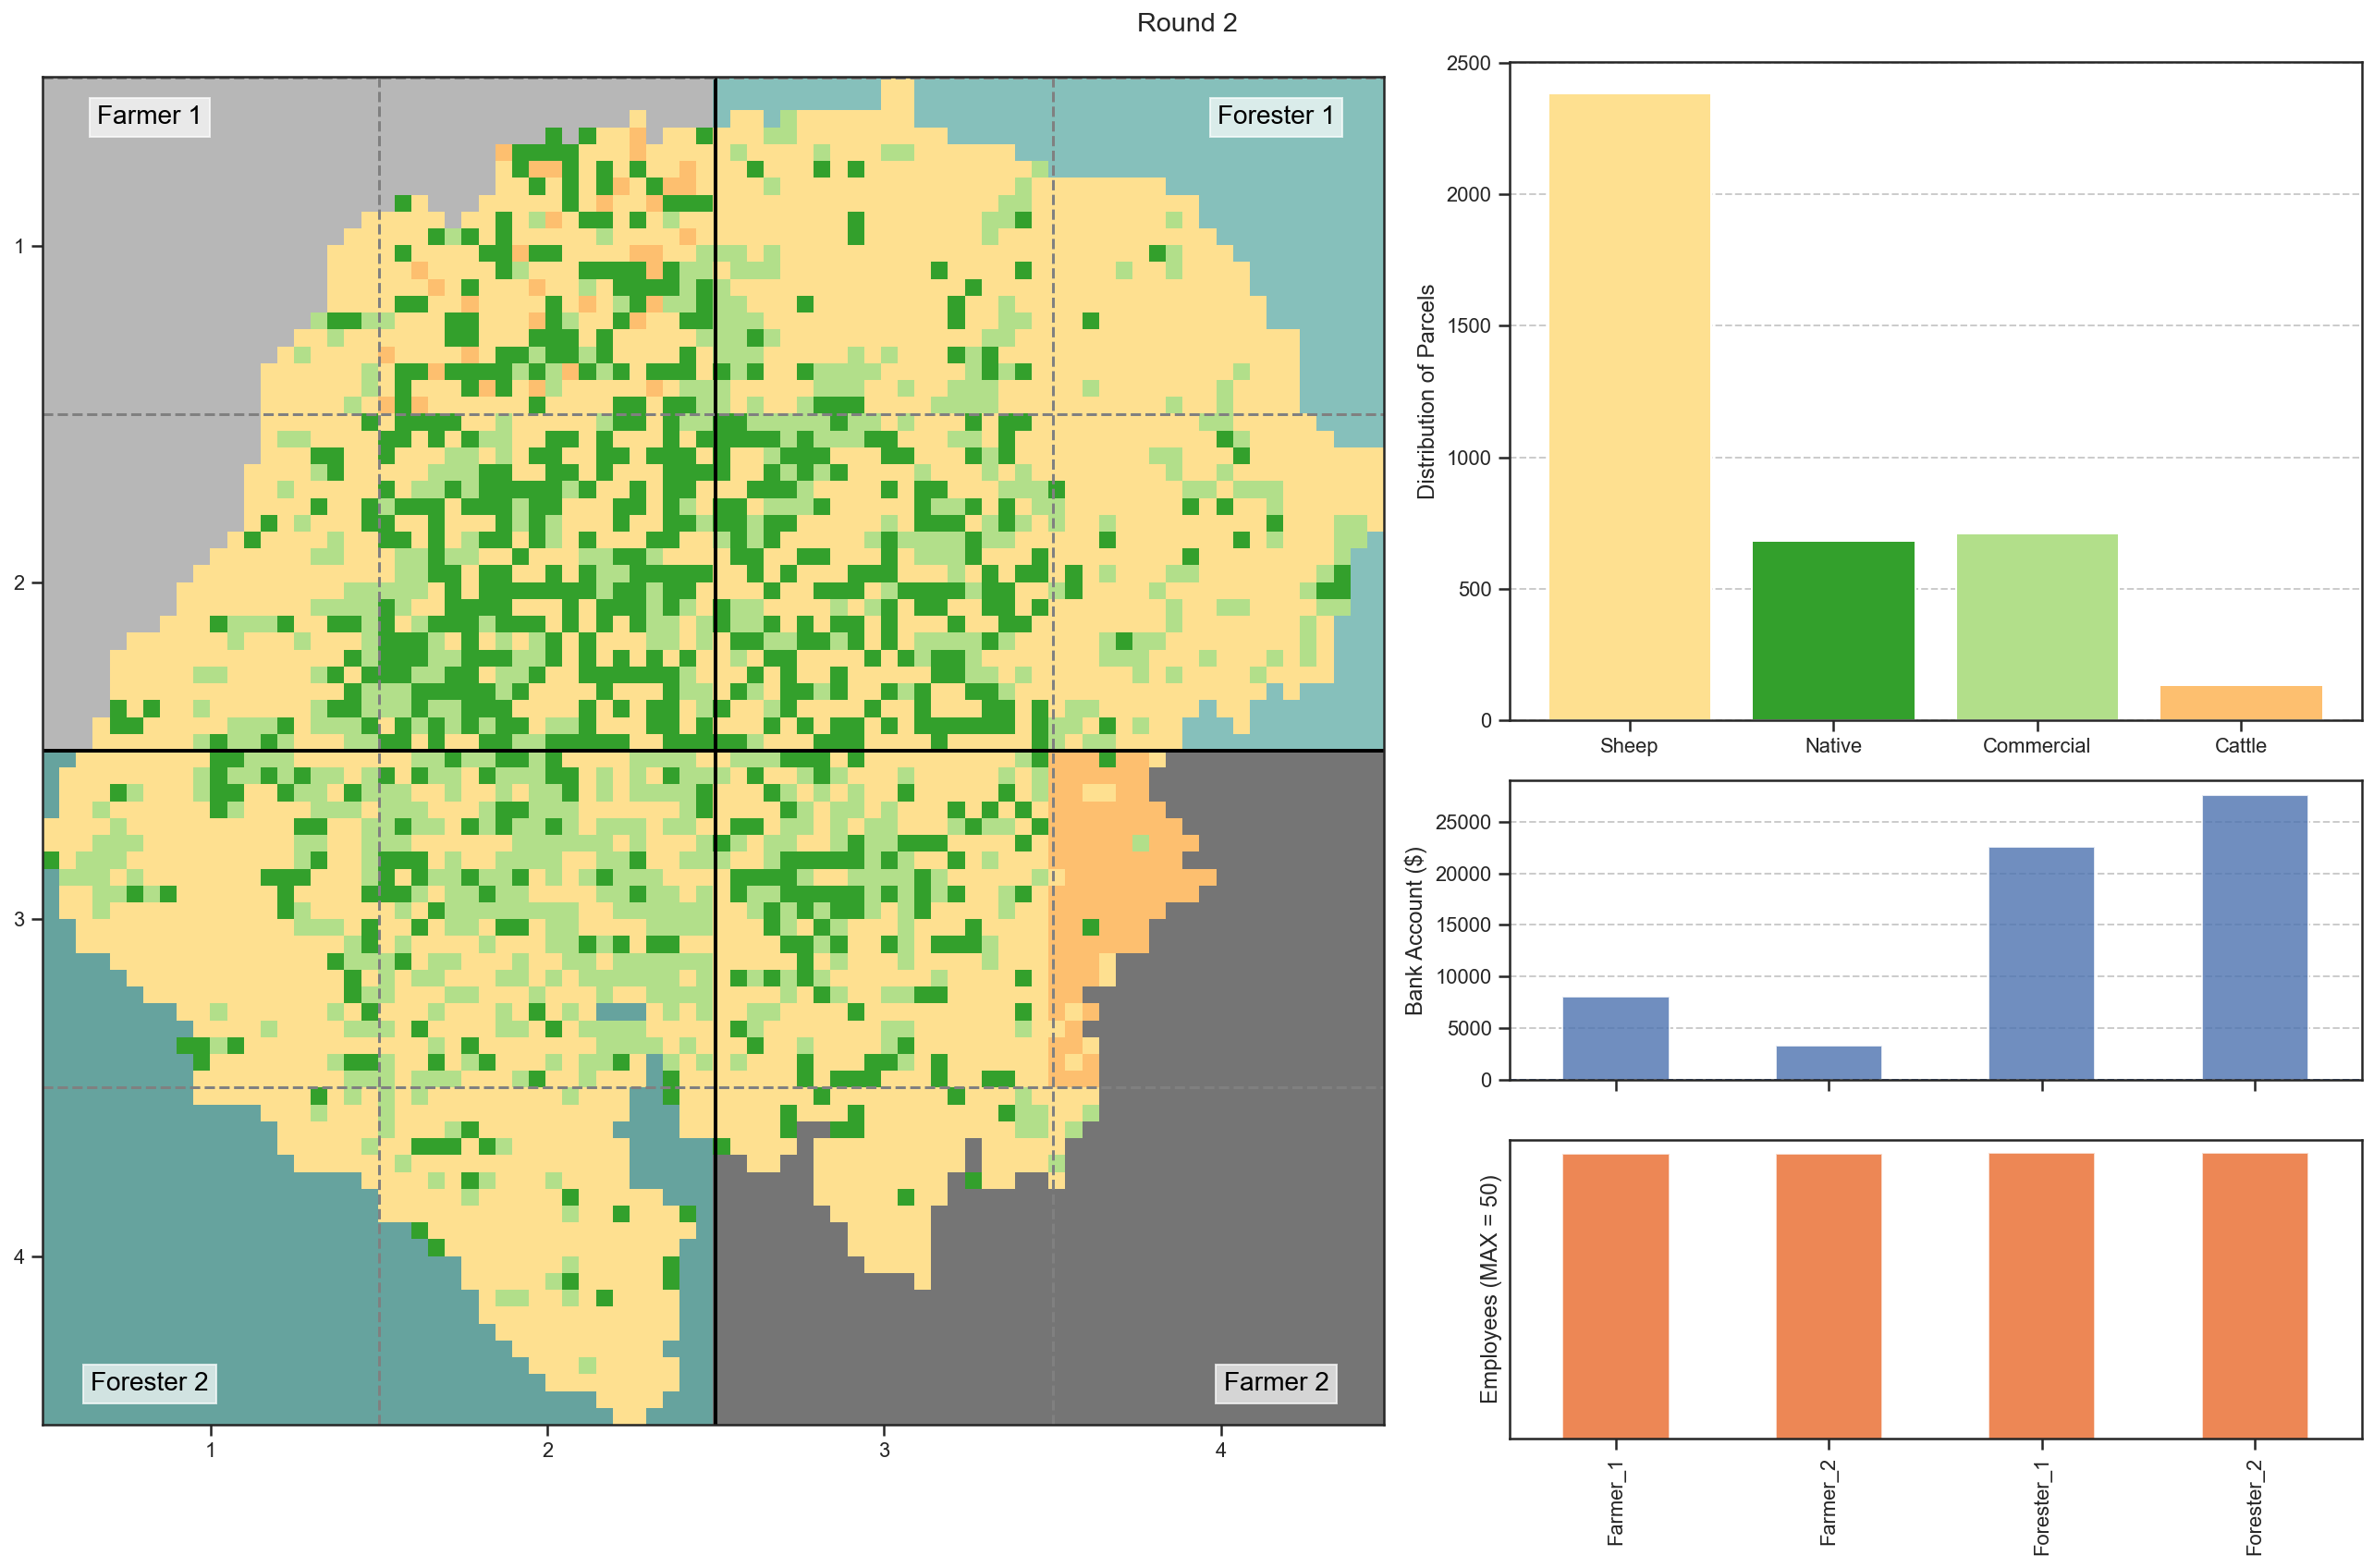

In [16]:
%reload_ext autoreload

# --------------------------------------------------------------------------
# 0. Updating round number
# --------------------------------------------------------------------------
matrix_game.update_round_number()
assert matrix_game.current_round == 2

# --------------------------------------------------------------------------
# 1. Downloading management decisions
# --------------------------------------------------------------------------

# download mgmt decisions
matrix_game.fetch_mgmt_decisions()

# visualize
# matrix_game.show_all_mgmt_decisions()

# --------------------------------------------------------------------------
# 2. Updating landscape
# --------------------------------------------------------------------------
matrix_game.update_lulc_matrix_based_on_mgmt_decisions(current_round=None)

# --------------------------------------------------------------------------
# 3. Updating property, incomes, bank accounts, and unemployment rates
# --------------------------------------------------------------------------
matrix_game.update_data_store(ssda_choice=33)

# --------------------------------------------------------------------------
# 4. Visualizing new dashboard
# --------------------------------------------------------------------------
matrix_game.show_dashboard(figure_size=(18,12), property_rights=True, cattle=True)

## Year 3

4
4
In this year, 514 tourists visited the biosphere.


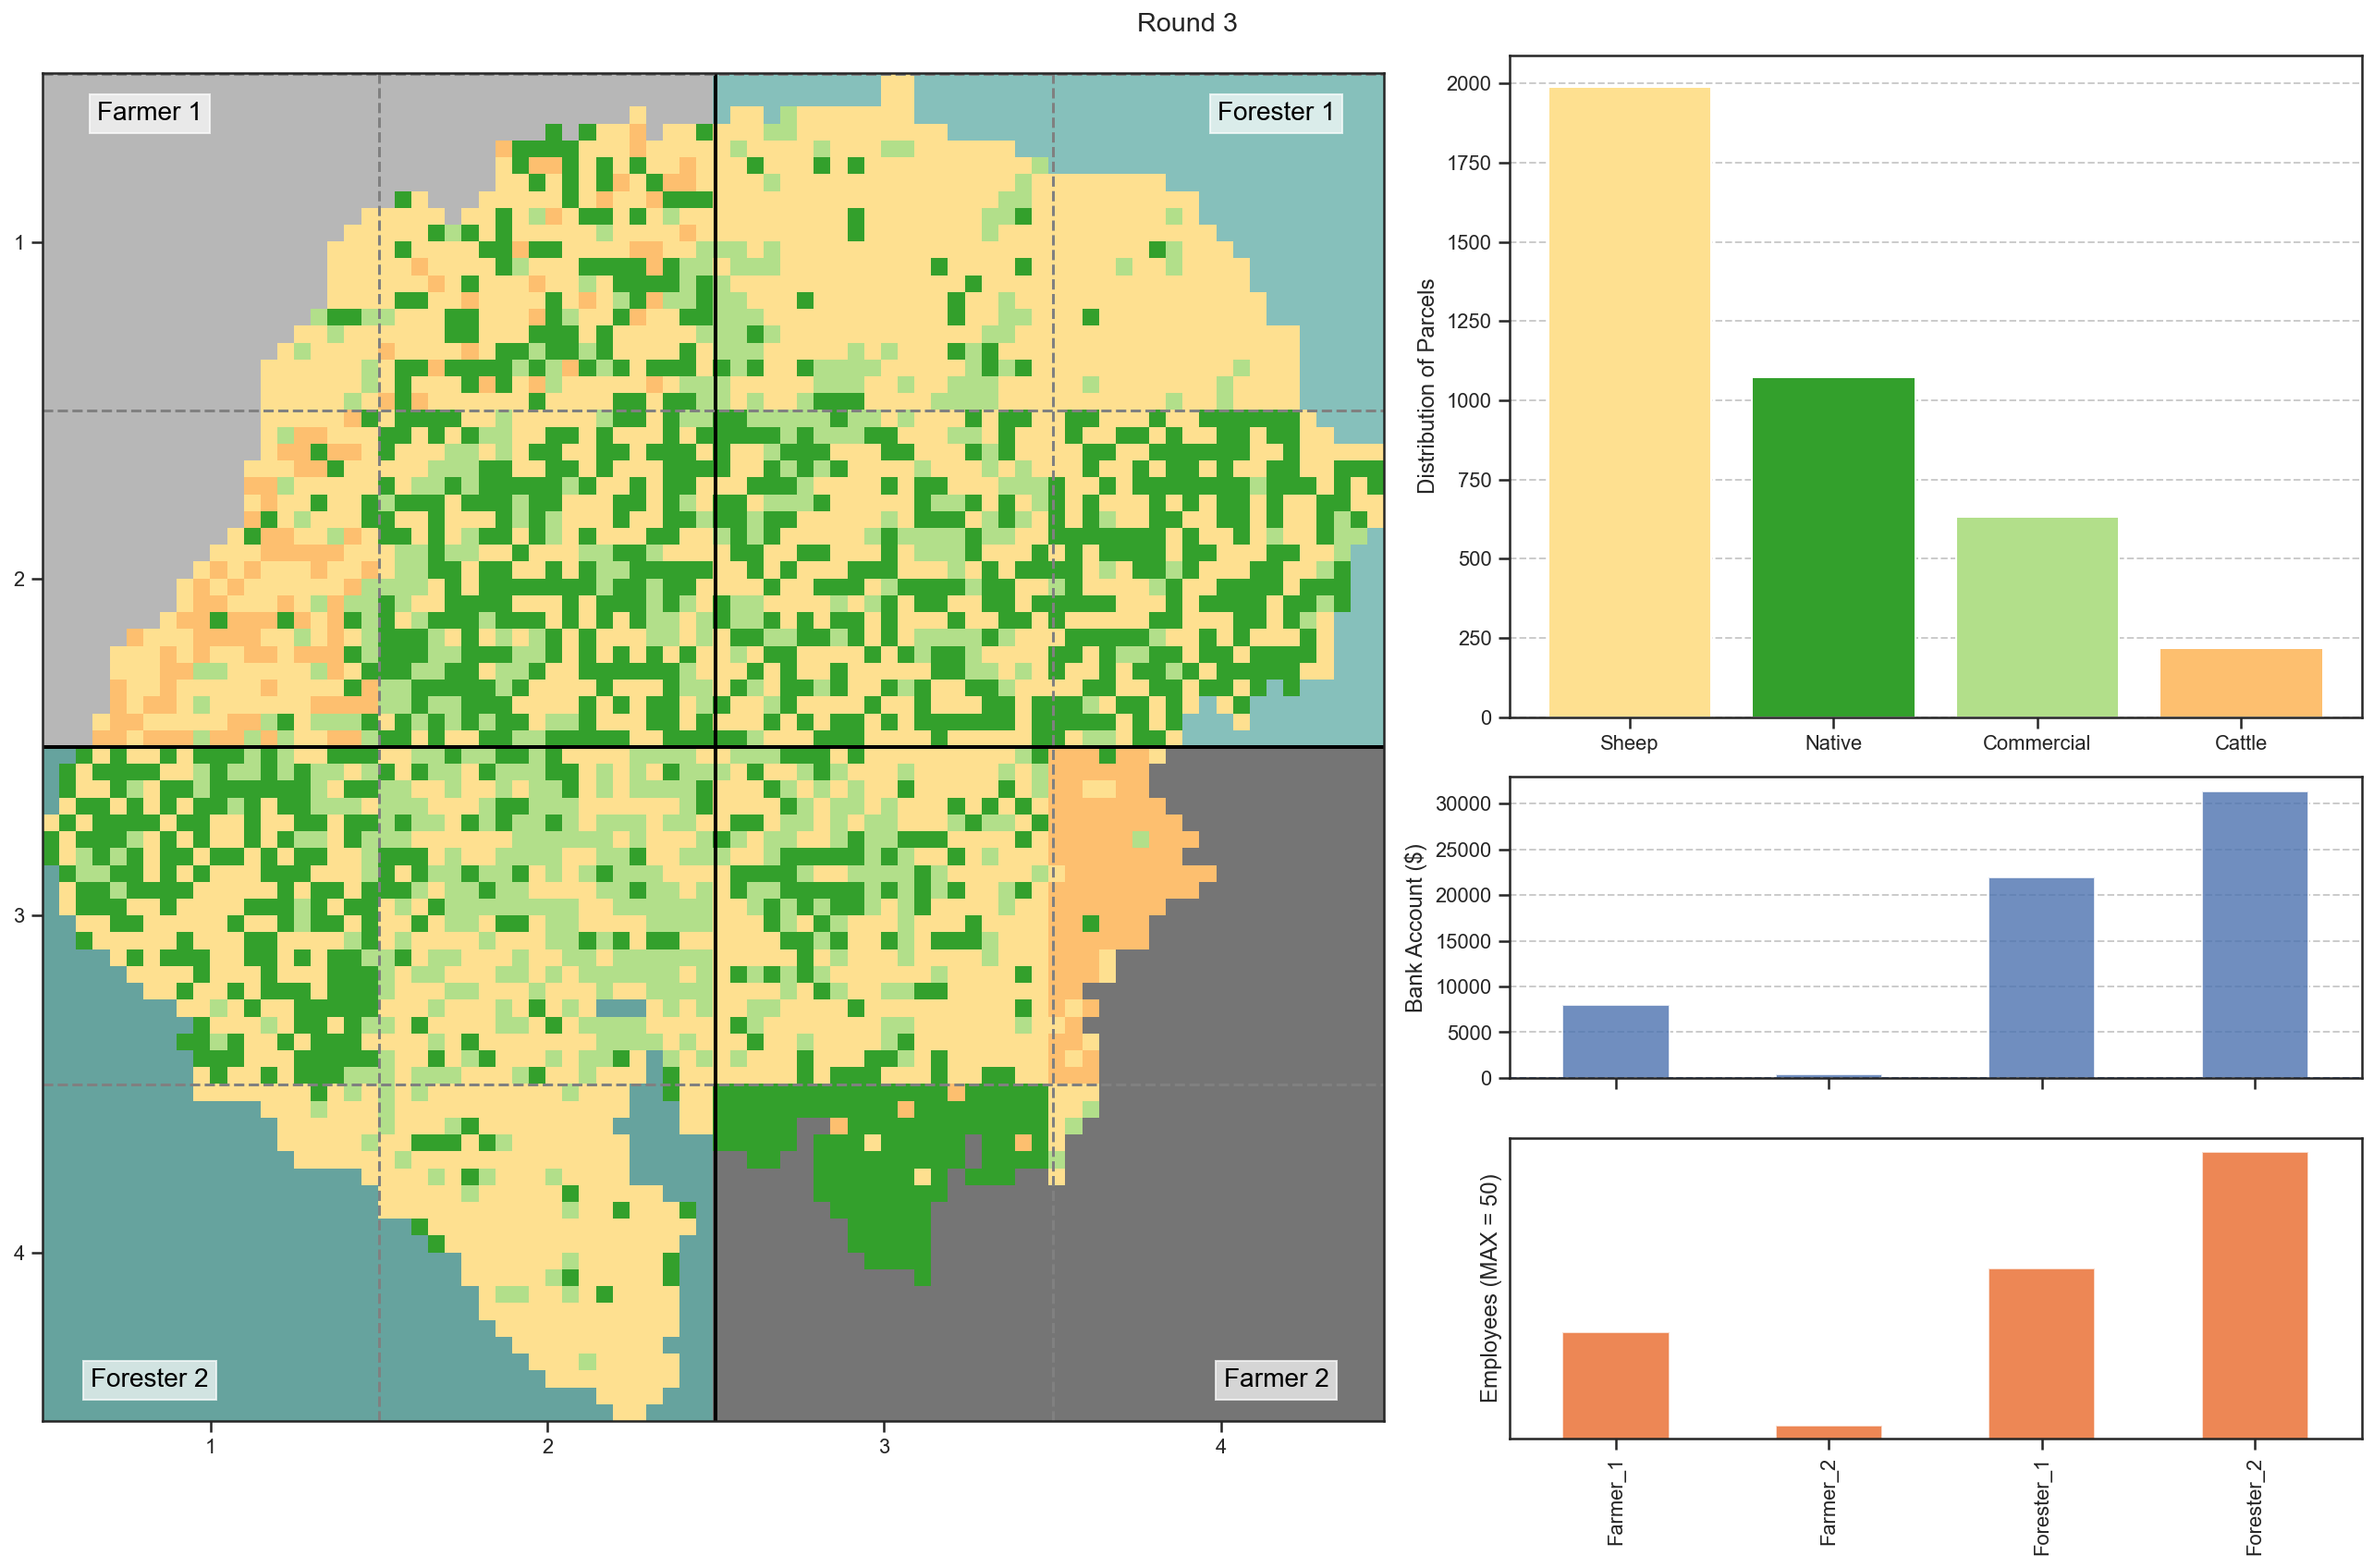

In [17]:
%reload_ext autoreload

# --------------------------------------------------------------------------
# 0. Updating round number
# --------------------------------------------------------------------------
matrix_game.update_round_number()
assert matrix_game.current_round == 3

# --------------------------------------------------------------------------
# 1. Downloading management decisions
# --------------------------------------------------------------------------

# download mgmt decisions
matrix_game.fetch_mgmt_decisions()

# visualize
# matrix_game.show_all_mgmt_decisions()

# --------------------------------------------------------------------------
# 2. Updating landscape
# --------------------------------------------------------------------------
matrix_game.update_lulc_matrix_based_on_mgmt_decisions(current_round=None)

# --------------------------------------------------------------------------
# 3. Updating property, incomes, bank accounts, and unemployment rates
# --------------------------------------------------------------------------
matrix_game.update_data_store(ssda_choice=22)

# --------------------------------------------------------------------------
# 4. Visualizing new dashboard
# --------------------------------------------------------------------------
matrix_game.show_dashboard(figure_size=(18,12), property_rights=True, cattle=True)

## Year 4 (BREXIT)

4
4
In this year, 454 tourists visited the biosphere.


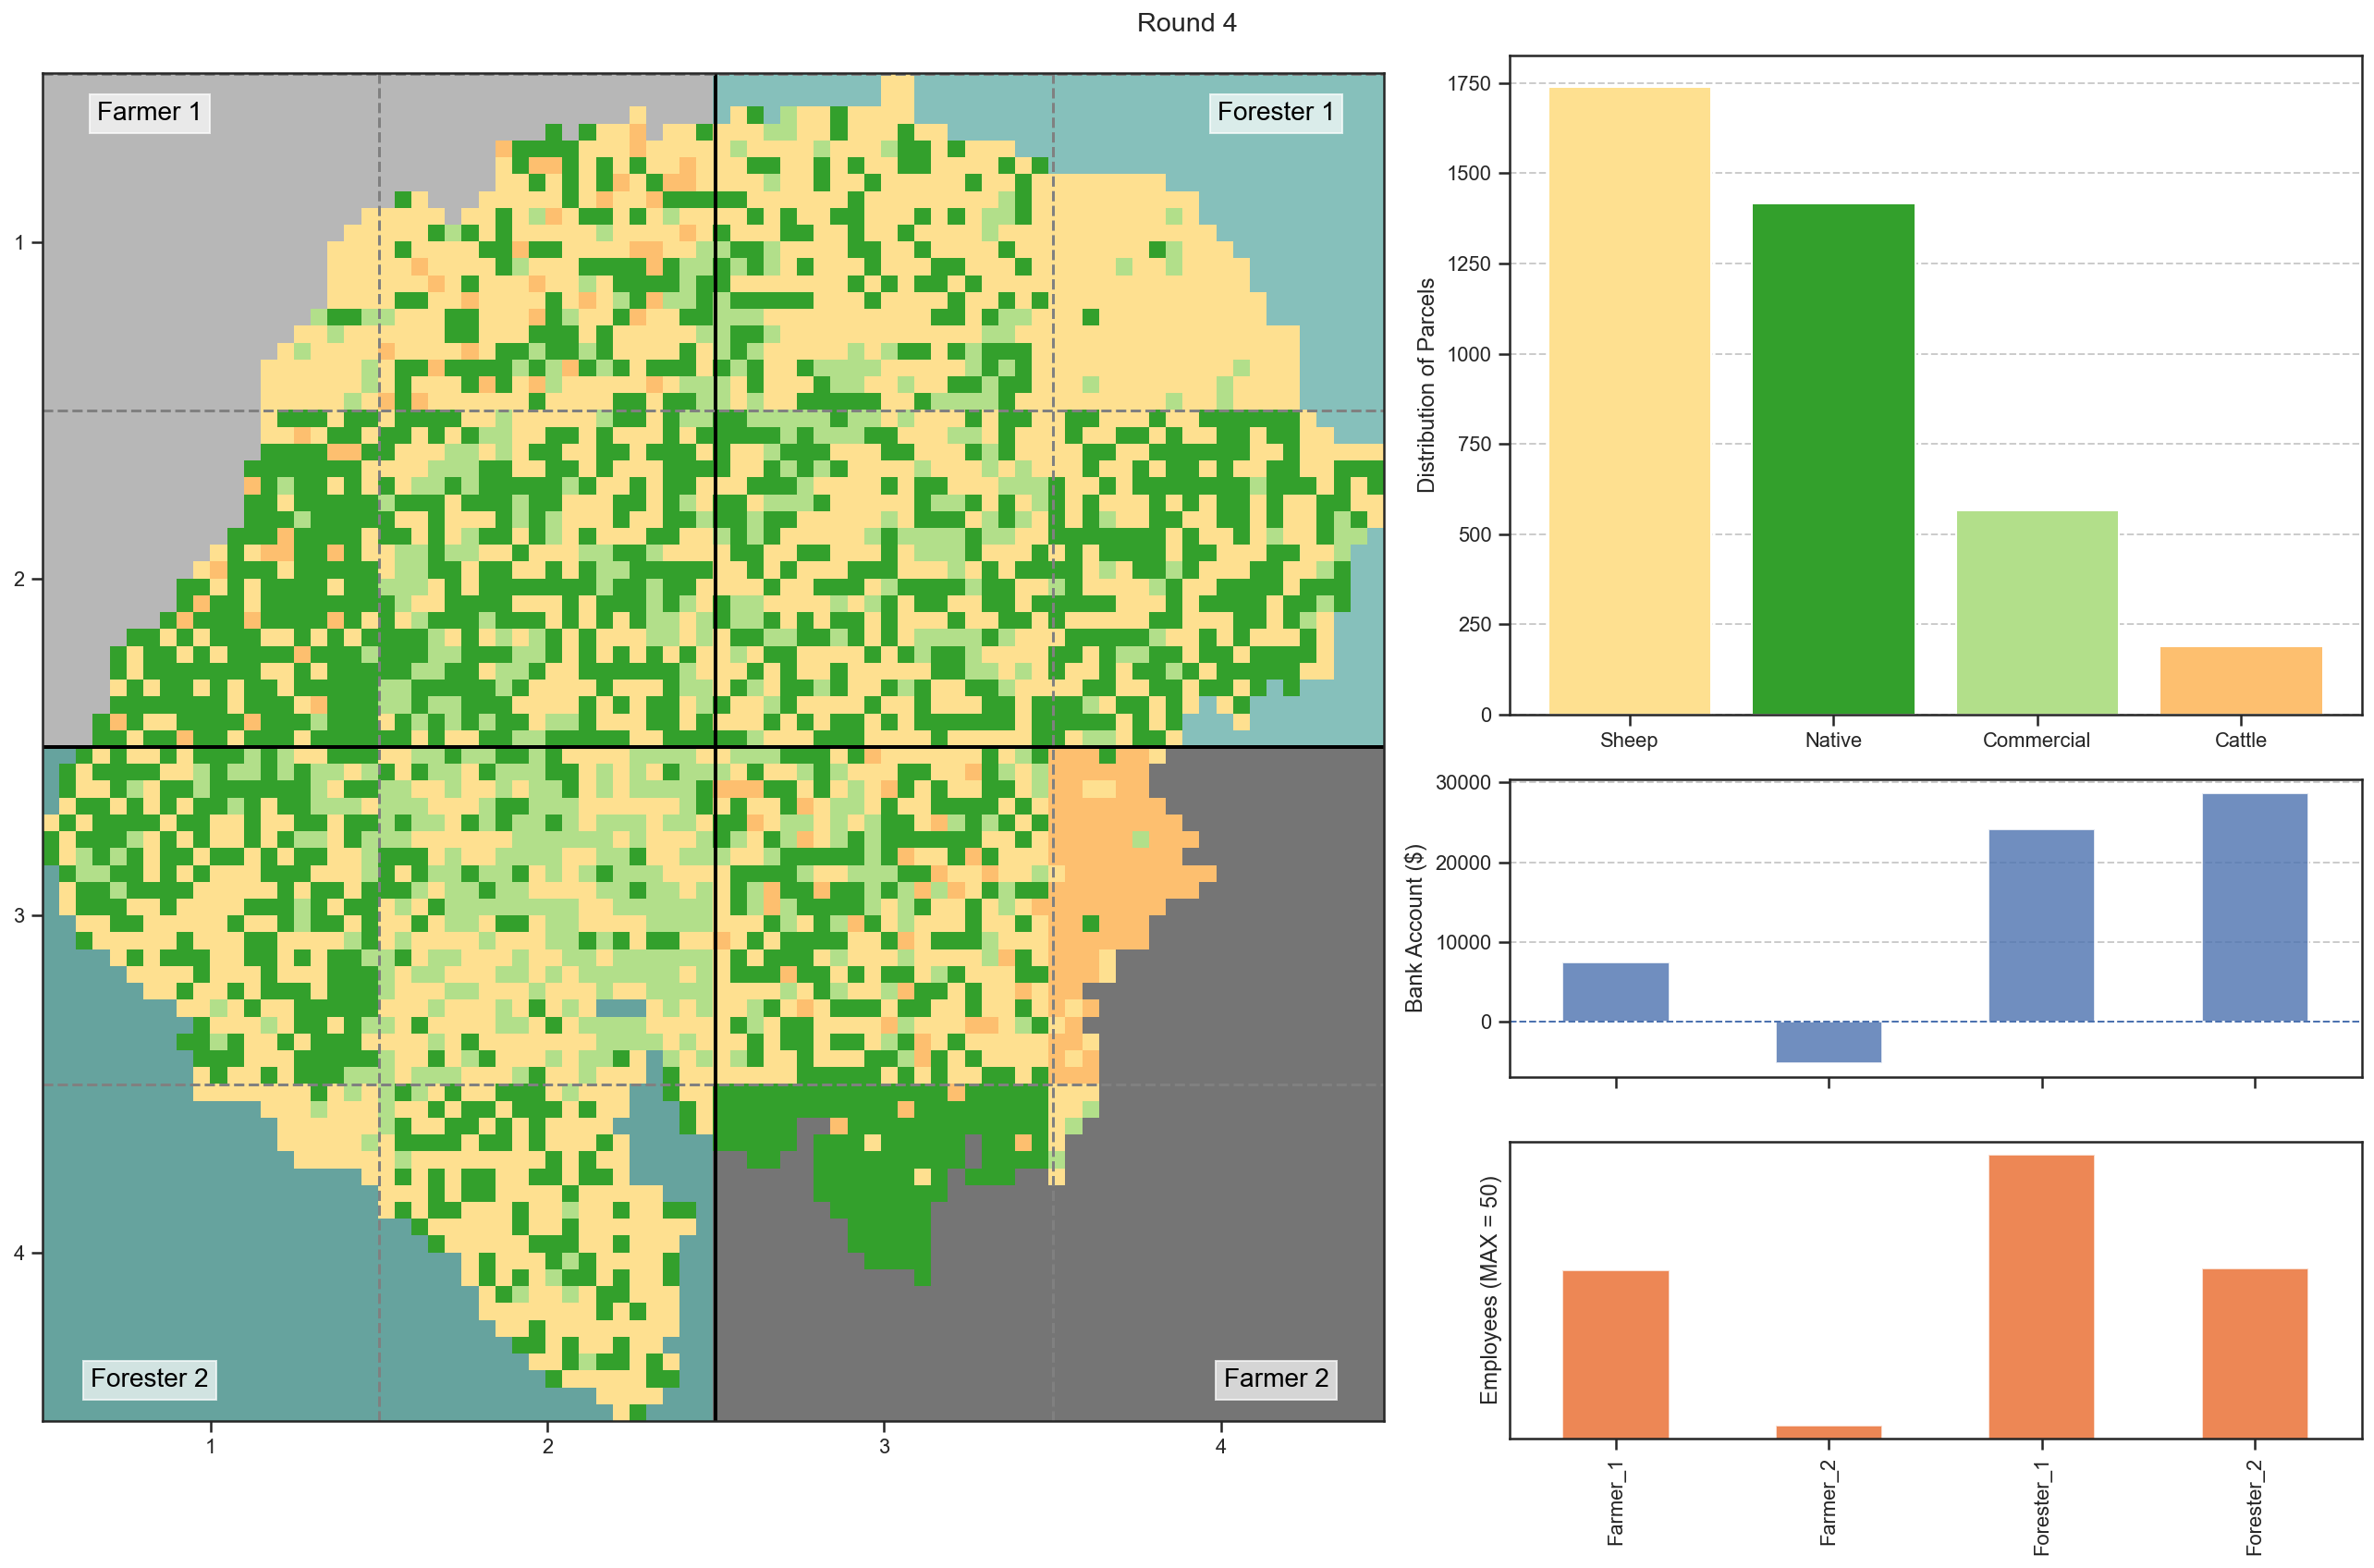

In [18]:
%reload_ext autoreload

# --------------------------------------------------------------------------
# 0. Updating round number
# --------------------------------------------------------------------------
matrix_game.update_round_number()
assert matrix_game.current_round == 4

# --------------------------------------------------------------------------
# 1. Downloading management decisions
# --------------------------------------------------------------------------

# download mgmt decisions
matrix_game.fetch_mgmt_decisions()

# visualize
# matrix_game.show_all_mgmt_decisions()

# --------------------------------------------------------------------------
# 2. Updating landscape
# --------------------------------------------------------------------------
matrix_game.update_lulc_matrix_based_on_mgmt_decisions(current_round=None)

# --------------------------------------------------------------------------
# 3. Updating property, incomes, bank accounts, and unemployment rates
# --------------------------------------------------------------------------
matrix_game.update_data_store(ssda_choice=13)

# --------------------------------------------------------------------------
# 4. Visualizing new dashboard
# --------------------------------------------------------------------------
matrix_game.show_dashboard(figure_size=(18,12), property_rights=True, cattle=True)

## Year 5

4
4
In this year, 347 tourists visited the biosphere.


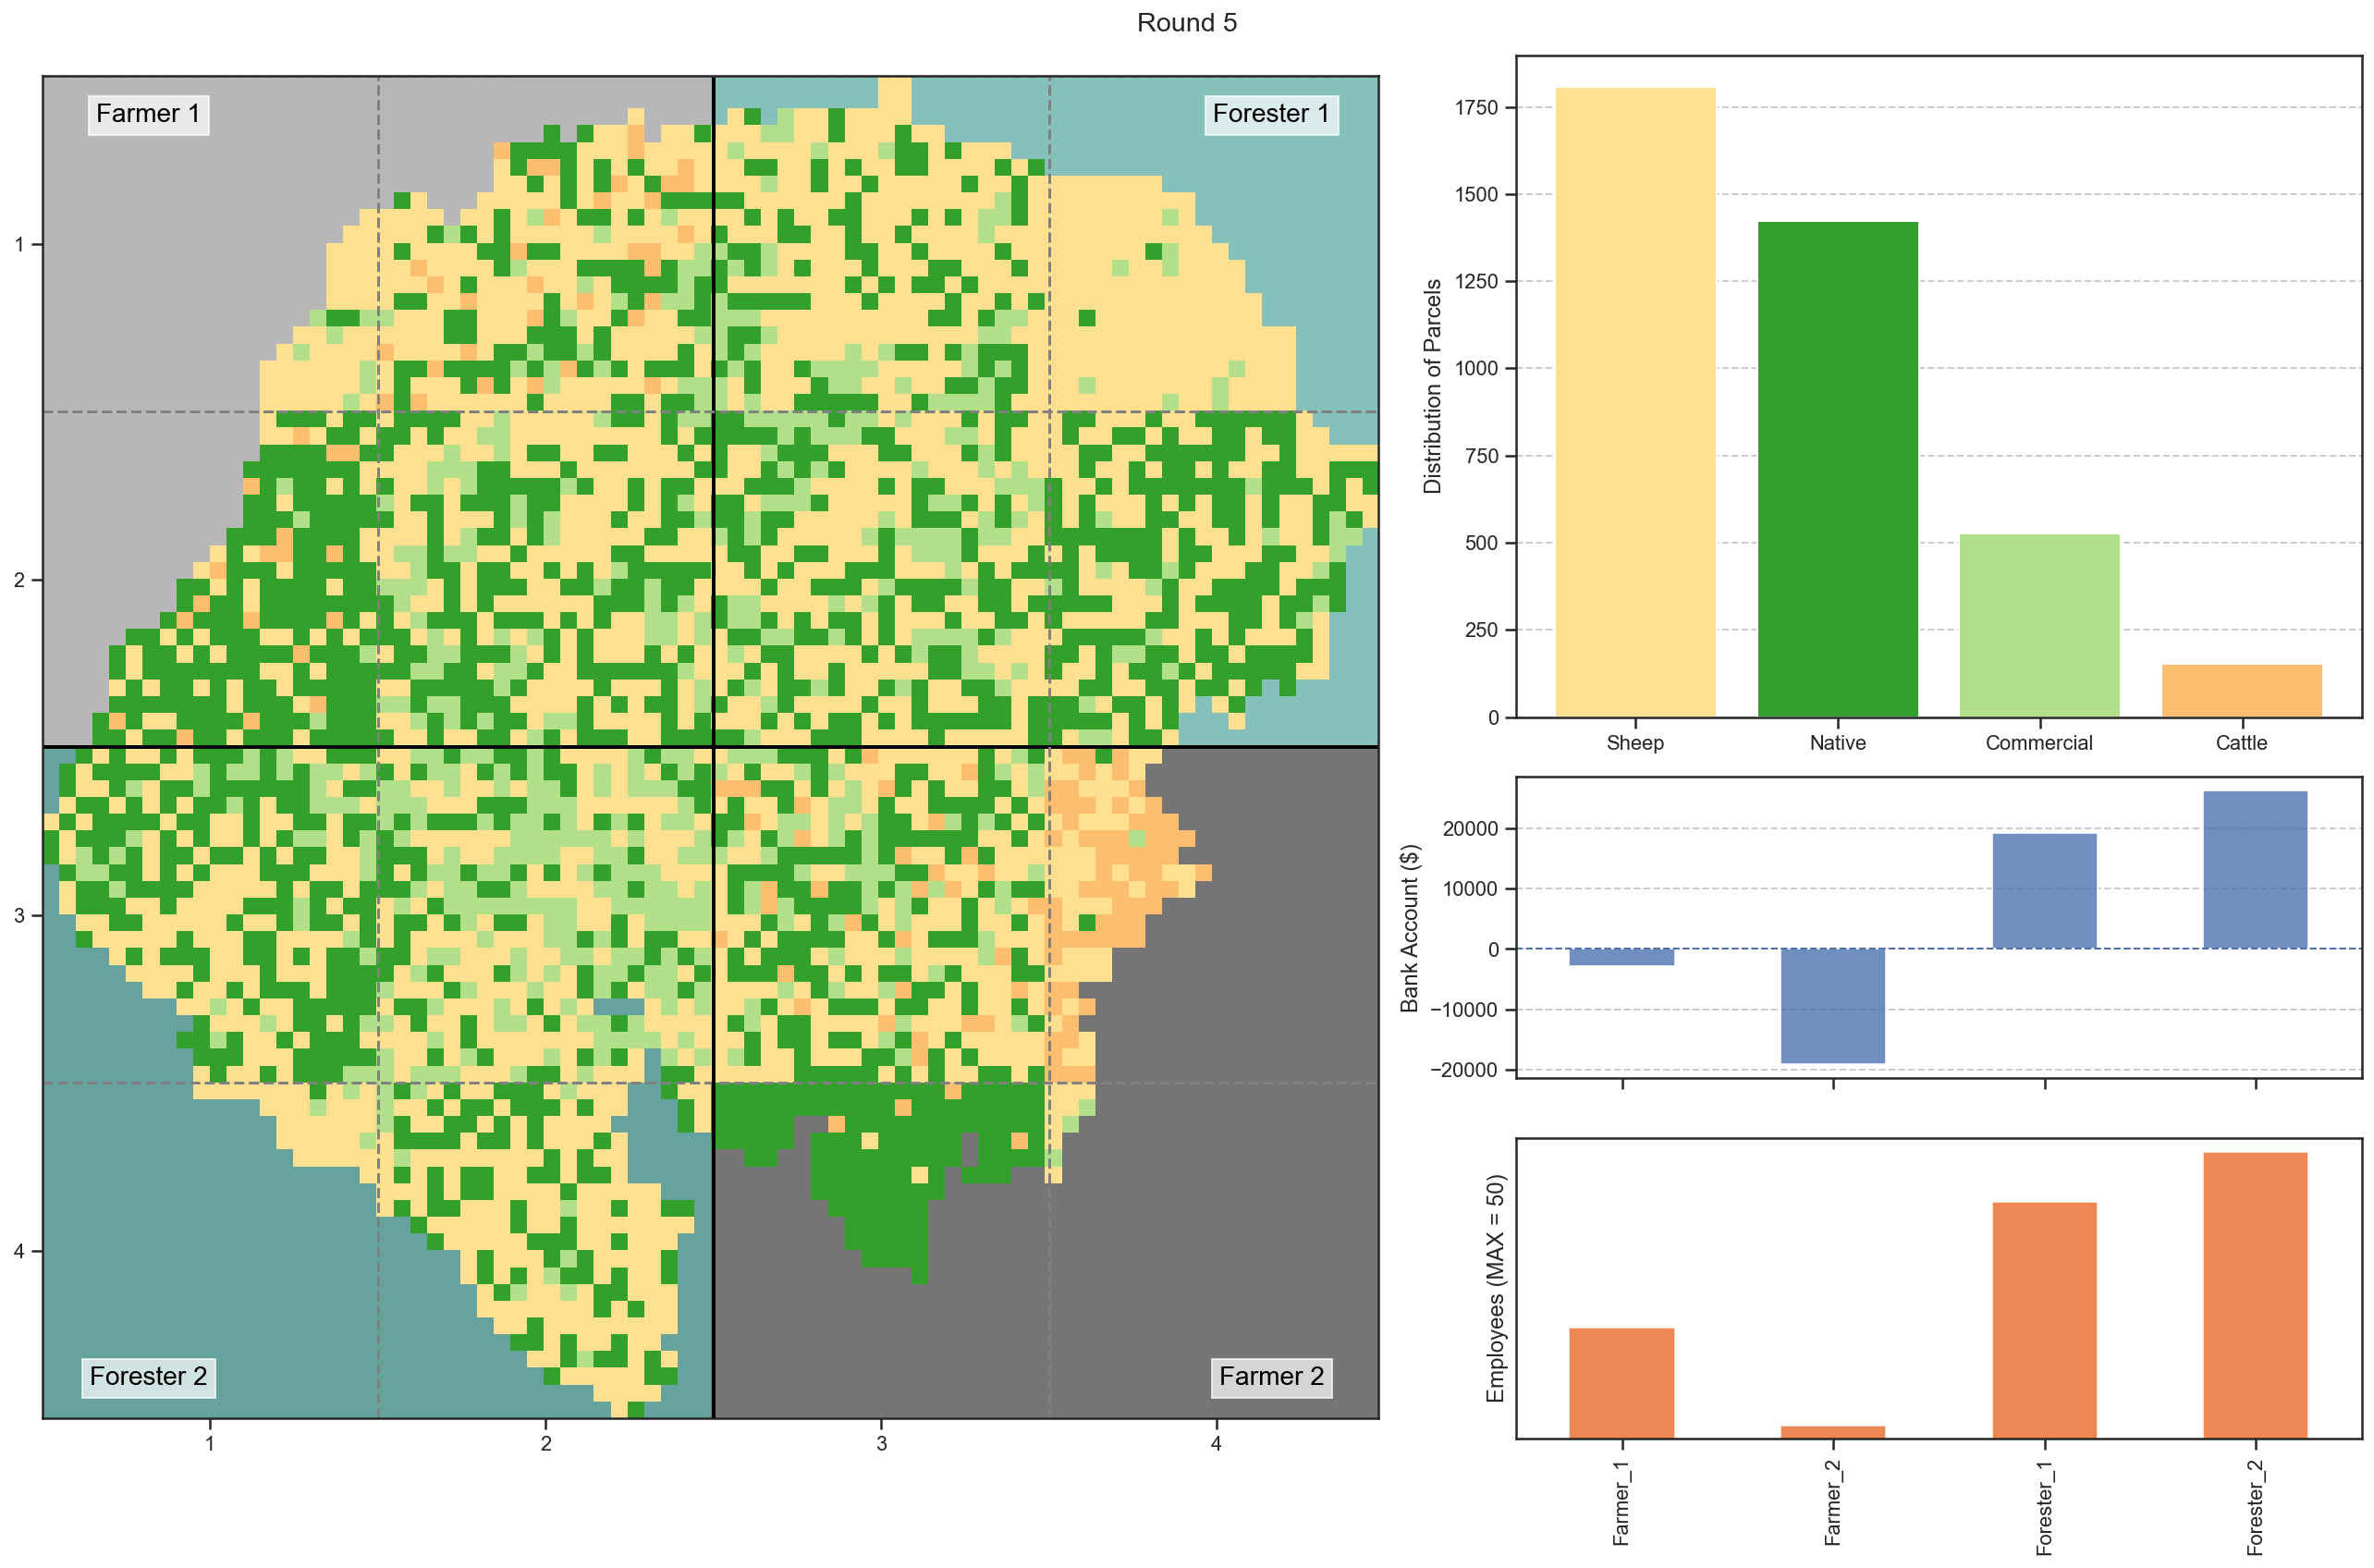

In [19]:
%reload_ext autoreload

# --------------------------------------------------------------------------
# 0. Updating round number
# --------------------------------------------------------------------------
matrix_game.update_round_number()
assert matrix_game.current_round == 5

# --------------------------------------------------------------------------
# 1. Downloading management decisions
# --------------------------------------------------------------------------

# download mgmt decisions
matrix_game.fetch_mgmt_decisions()

# visualize
# matrix_game.show_all_mgmt_decisions()

# --------------------------------------------------------------------------
# 2. Updating landscape
# --------------------------------------------------------------------------
matrix_game.update_lulc_matrix_based_on_mgmt_decisions(current_round=None)

# --------------------------------------------------------------------------
# 3. Updating property, incomes, bank accounts, and unemployment rates
# --------------------------------------------------------------------------
matrix_game.update_data_store(ssda_choice=14)

# --------------------------------------------------------------------------
# 4. Visualizing new dashboard
# --------------------------------------------------------------------------
matrix_game.show_dashboard(figure_size=(18,12), property_rights=True, cattle=True)

## Year 6

4
4
In this year, 347 tourists visited the biosphere.


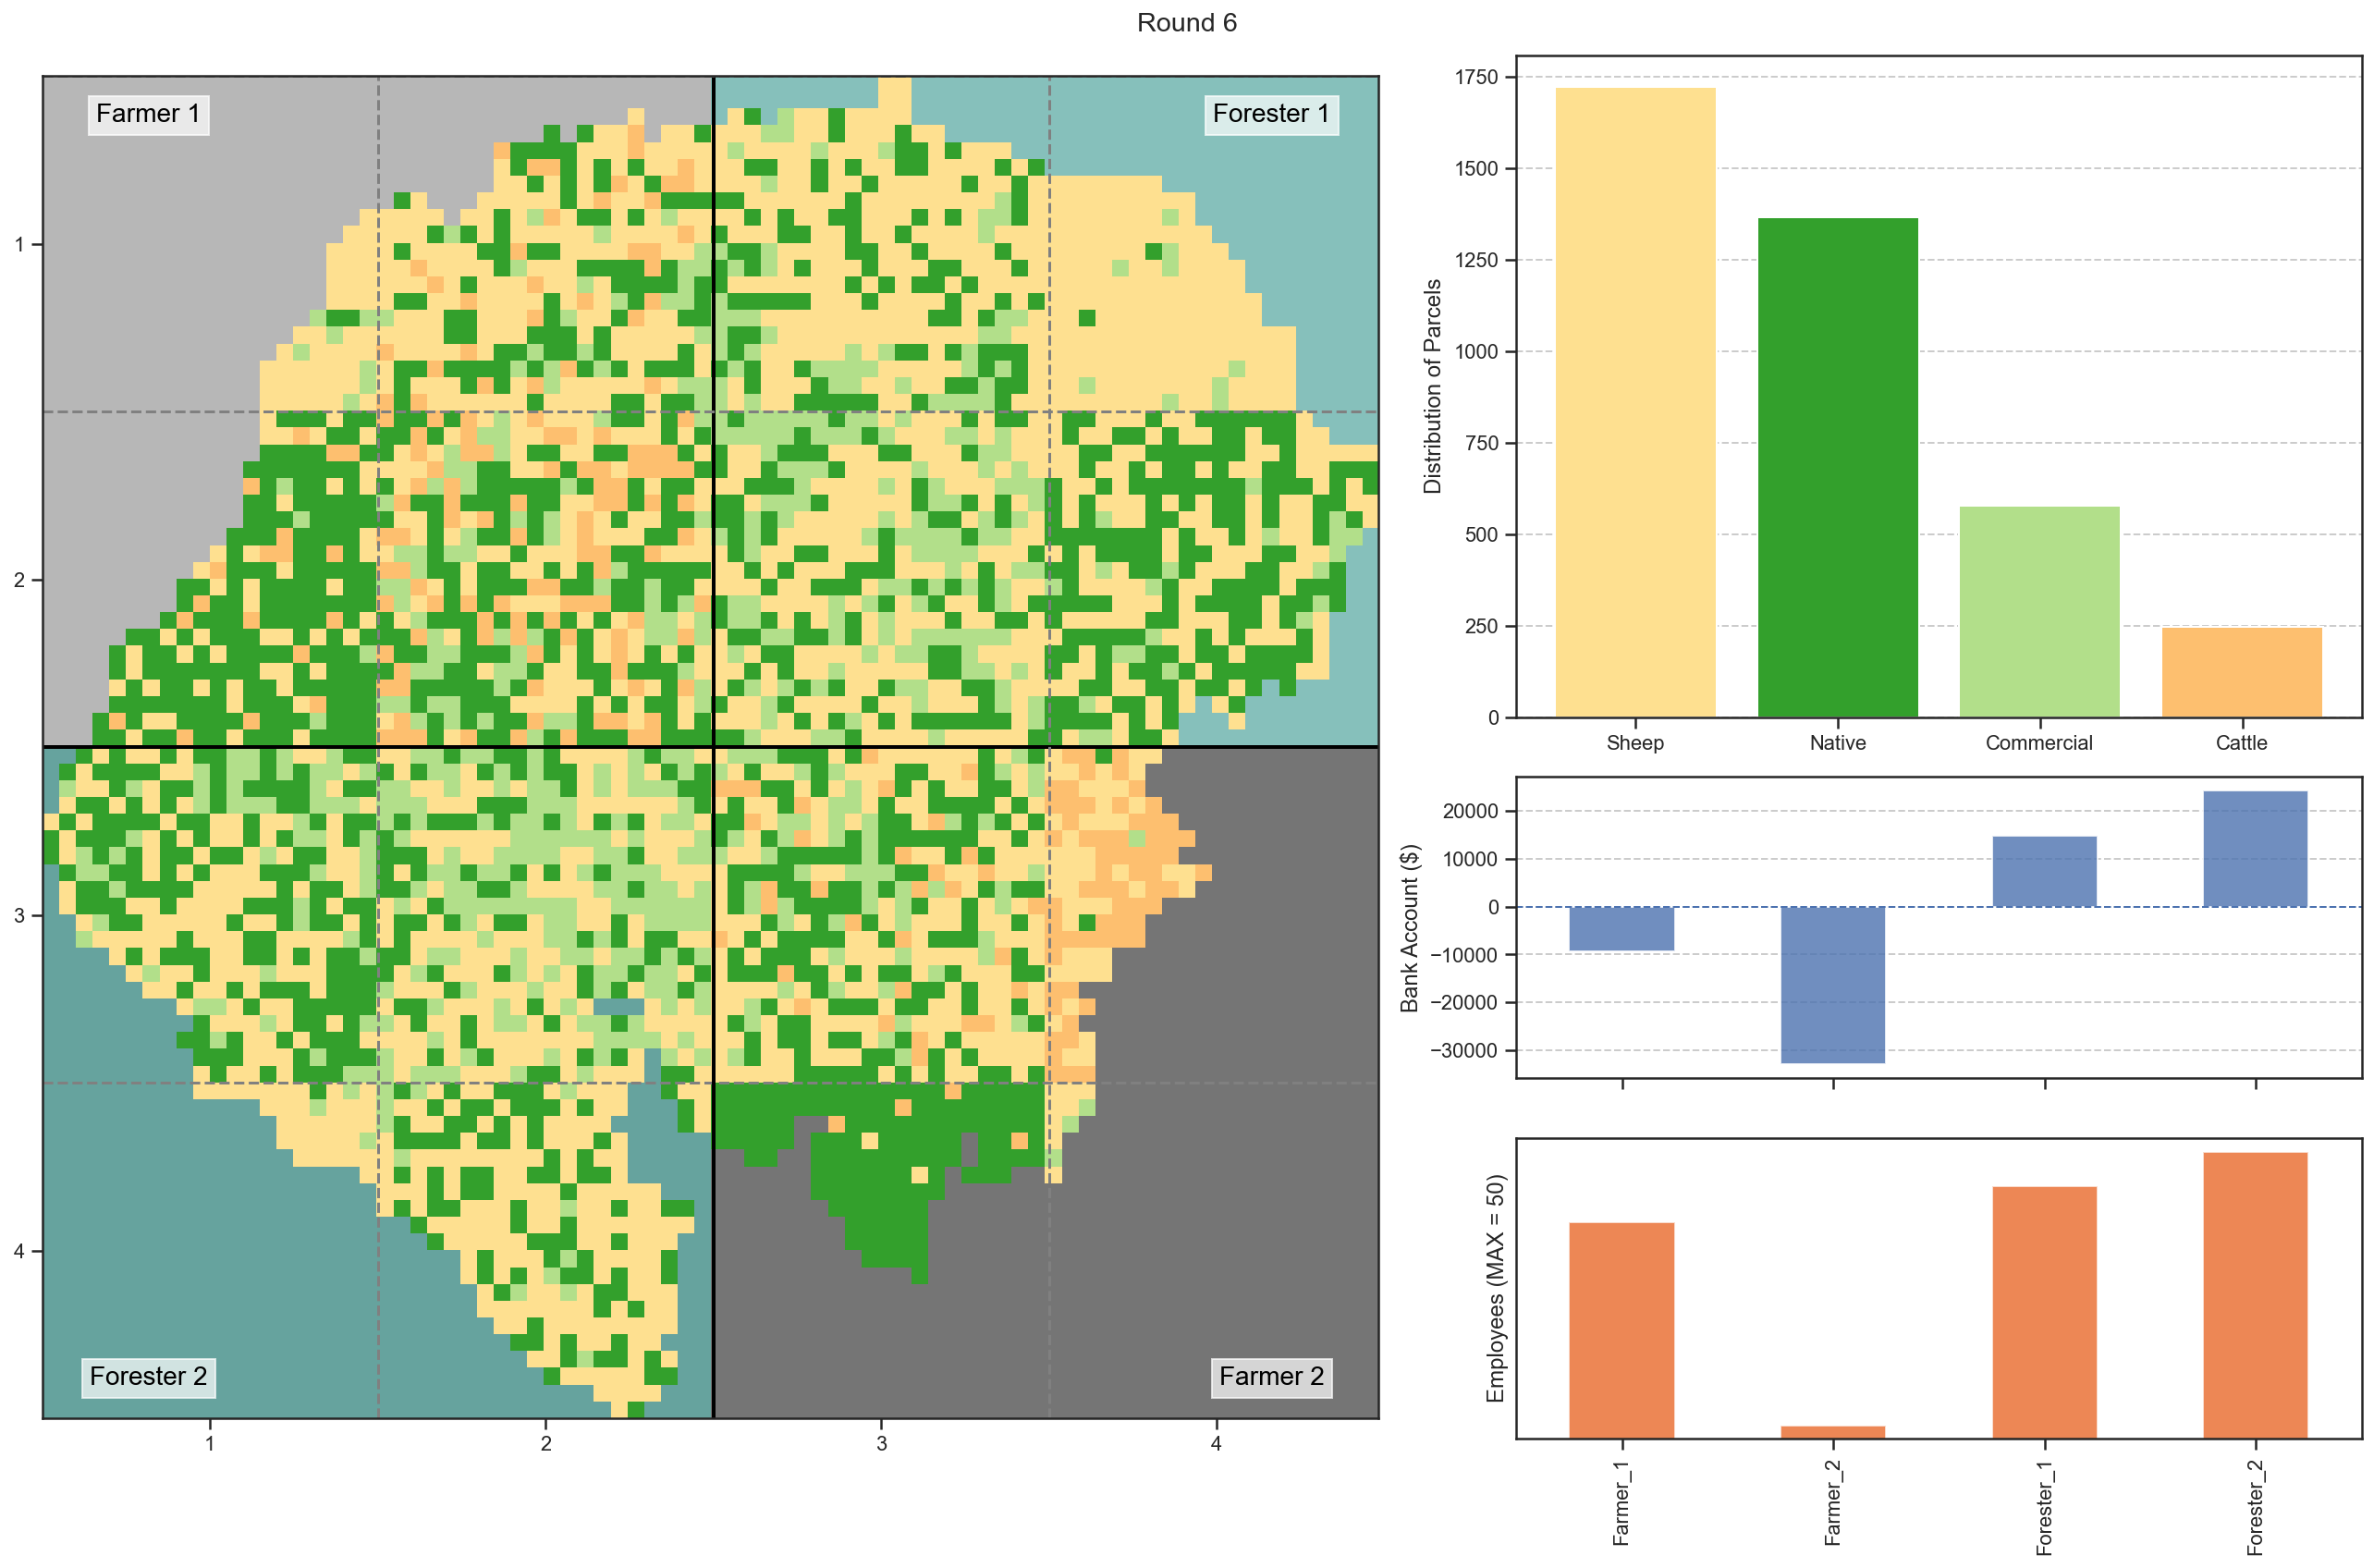

In [20]:
%reload_ext autoreload

# --------------------------------------------------------------------------
# 0. Updating round number
# --------------------------------------------------------------------------
matrix_game.update_round_number()
assert matrix_game.current_round == 6

# --------------------------------------------------------------------------
# 1. Downloading management decisions
# --------------------------------------------------------------------------

# download mgmt decisions
matrix_game.fetch_mgmt_decisions()

# visualize
# matrix_game.show_all_mgmt_decisions()

# --------------------------------------------------------------------------
# 2. Updating landscape
# --------------------------------------------------------------------------
matrix_game.update_lulc_matrix_based_on_mgmt_decisions(current_round=None)

# --------------------------------------------------------------------------
# 3. Updating property, incomes, bank accounts, and unemployment rates
# --------------------------------------------------------------------------
matrix_game.update_data_store(ssda_choice=14)

# --------------------------------------------------------------------------
# 4. Visualizing new dashboard
# --------------------------------------------------------------------------
matrix_game.show_dashboard(figure_size=(18,12), property_rights=True, cattle=True)